In [79]:
import numpy as np
import os
import argparse
from GridDataGen.utils.io import *
from GridDataGen.utils.process_network import *
from GridDataGen.utils.config import *
from GridDataGen.utils.stats import *
from GridDataGen.utils.param_handler import *
from GridDataGen.utils.load import *
from pandapower.auxiliary import pandapowerNet
import gc
from datetime import datetime
from tqdm import tqdm
from GridDataGen.utils.topology_perturbation import initialize_generator
import psutil
import shutil
import yaml
from GridDataGen.utils.process_network import process_scenario_contingency
from tqdm import tqdm


In [80]:
def compute_branch_currents_kA(Yf, Yt, V, Vf_base_kV, Vt_base_kV, sn_mva):

    
    If_pu = Yf @ V  # From-end currents in per-unit (I_f = Y_f V)
    If_kA = np.abs(If_pu) * sn_mva / (np.sqrt(3) * Vf_base_kV)  # Conversion to kA

    # Construct to-end admittance matrix Yt:
    # Yt[b, :] = y_tf_b * e_f + y_tt_b * e_t
    It_pu = Yt @ V  # To-end currents in per-unit (I_t = Y_t V)
    It_kA = np.abs(It_pu) * sn_mva / (np.sqrt(3) * Vt_base_kV)  # Conversion to kA


    return If_kA, It_kA


def compute_loading(If_kA, It_kA, Vf_base_kV, Vt_base_kV, rate_a):
    """
    Compute per-branch loading using current magnitudes and branch ratings.

    Parameters:
    - edge_index: np.ndarray of shape (n_edges, 2), each row is [from_bus, to_bus]
    - If_kA: np.ndarray of from-side current magnitudes in kA
    - It_kA: np.ndarray of to-side current magnitudes in kA
    - base_kv: np.ndarray of shape (n_buses,), base voltage in kV per bus
    - edge_attr: np.ndarray of shape (n_edges, >=5), edge features, column 4 = RATE_A

    Returns:
    - loading: np.ndarray of shape (n_edges,), max of from and to side loading
    """

    limitf = rate_a / (Vf_base_kV * np.sqrt(3))
    limitt = rate_a / (Vt_base_kV * np.sqrt(3))

    loadingf = If_kA / limitf
    loadingt = It_kA / limitt

    return np.maximum(loadingf, loadingt)

In [81]:
pf_edge = pd.read_csv("../../data_contingency/case300_ieee/raw/pf_edge.csv")
pf_node = pd.read_csv("../../data_contingency/case300_ieee/merged/GridFM_v0.1.2_case300_ieee_output_pf_node.csv")
branch_idx_removed = pd.read_csv("../../data_contingency/case300_ieee/raw/branch_idx_removed.csv")
edge_params = pd.read_csv("../../data_contingency/case300_ieee/raw/edge_params.csv")
bus_params = pd.read_csv("../../data_contingency/case300_ieee/raw/bus_params.csv")

In [82]:
base_kv = bus_params["baseKV"].values
sn_mva = 100

# Extract from-bus and to-bus indices for each branch

f = edge_params["from_bus"].values.astype(np.int32)
t = edge_params["to_bus"].values.astype(np.int32)

# Extract branch admittance coefficients
Yff = edge_params["Yff_r"].values + 1j * edge_params["Yff_i"].values
Yft = edge_params["Yft_r"].values + 1j * edge_params["Yft_i"].values
Ytf = edge_params["Ytf_r"].values + 1j * edge_params["Ytf_i"].values
Ytt = edge_params["Ytt_r"].values + 1j * edge_params["Ytt_i"].values

# Get base voltages for the from and to buses (for kA conversion)
Vf_base_kV = base_kv[f]
Vt_base_kV = base_kv[t]

nl = edge_params.shape[0]
nb = bus_params.shape[0]

# i = [0, 1, ..., nl-1, 0, 1, ..., nl-1], used for constructing Yf and Yt
i = np.hstack([np.arange(nl), np.arange(nl)])

# Construct from-end admittance matrix Yf using the linear combination:
# Yf[b, :] = y_ff_b * e_f + y_ft_b * e_t
Yf = csr_matrix((np.hstack([Yff, Yft]), (i, np.hstack([f, t]))), shape=(nl, nb))
Yt = csr_matrix((np.hstack([Ytf, Ytt]), (i, np.hstack([f, t]))), shape=(nl, nb))

rate_a = edge_params["rate_a"].values

In [83]:
pf_node["VM_pred_corrected"] = pf_node["VM_pred"]
pf_node["VA_pred_corrected"] = pf_node["VA_pred"]

pf_node.loc[pf_node.PV, "VM_pred_corrected"] = pf_node["Vm"]
pf_node.loc[pf_node.REF, "VA_pred_corrected"] = pf_node["Va"]

In [84]:
loadings = []
loadings_pred = []
for scenario_idx in tqdm(pf_node.scenario.unique()):
    pf_node_scenario = pf_node[pf_node.scenario == scenario_idx]
    branch_idx_removed_scenario = branch_idx_removed[branch_idx_removed.scenario == scenario_idx].iloc[:, 1:].values
    # remove nan
    branch_idx_removed_scenario = branch_idx_removed_scenario[~np.isnan(branch_idx_removed_scenario)].astype(np.int32)
    V_true = pf_node_scenario["Vm"].values * np.exp(1j * pf_node_scenario["Va"].values * np.pi / 180)
    V_pred = pf_node_scenario["VM_pred_corrected"].values * np.exp(1j * pf_node_scenario["VA_pred_corrected"].values * np.pi / 180)
    If_true, It_true = compute_branch_currents_kA(Yf, Yt, V_true, Vf_base_kV, Vt_base_kV, sn_mva)
    If_pred, It_pred = compute_branch_currents_kA(Yf, Yt, V_pred, Vf_base_kV, Vt_base_kV, sn_mva)
    loading_true = compute_loading(If_true, It_true, Vf_base_kV, Vt_base_kV, rate_a)
    loading_pred = compute_loading(If_pred, It_pred, Vf_base_kV, Vt_base_kV, rate_a)
    # remove the branches that are removed from loading
    loading_true[branch_idx_removed_scenario] = -1
    loading_pred[branch_idx_removed_scenario] = -1
    loadings.append(loading_true)
    loadings_pred.append(loading_pred)

loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)
    

    

  0%|          | 0/10234 [00:00<?, ?it/s]

100%|██████████| 10234/10234 [00:24<00:00, 424.11it/s]


In [85]:
loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)

In [86]:
removed_lines = (loadings == -1)
removed_lines_pred = (loadings_pred == -1)

# assert the same lines are removed
assert (removed_lines == removed_lines_pred).all()

# assert the same number of lines are removed
assert (removed_lines.sum() == removed_lines_pred.sum())



In [87]:
overloadings = loadings > 1
overloadings_pred = loadings_pred > 1


In [88]:
# compute TPR, FPR, TNR, FNR
TPR = (overloadings & overloadings_pred).sum() / overloadings.sum()
FPR = (overloadings & ~overloadings_pred).sum() / (~overloadings).sum()
TNR = (~overloadings & ~overloadings_pred).sum() / (~overloadings).sum()
FNR = (overloadings & ~overloadings_pred).sum() / overloadings.sum()

print(f"TPR: {TPR}, FPR: {FPR}, TNR: {TNR}, FNR: {FNR}")




TPR: 0.27713681667170037, FPR: 0.0028563456486138715, TNR: 0.9988302038920485, FNR: 0.7228631833282996


In [89]:
# create df from loadings
loadings_df = pd.DataFrame(loadings)
loadings_df.columns = [f"branch_{i}" for i in range(loadings_df.shape[1])]

loadings_pred_df = pd.DataFrame(loadings_pred)
loadings_pred_df.columns = [f"branch_{i}" for i in range(loadings_pred_df.shape[1])]


In [90]:
import matplotlib.pyplot as plt

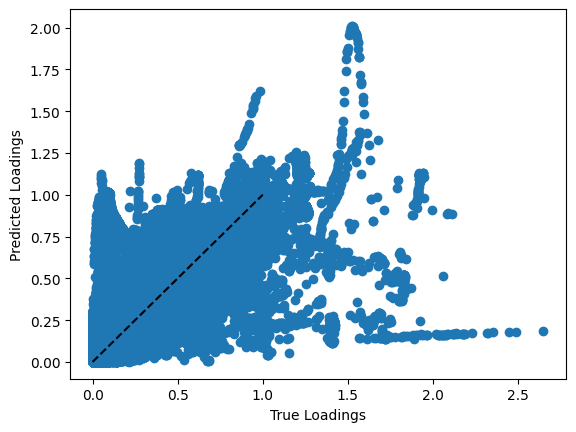

In [91]:
# scatter plot of loadings and loadings_pred
plt.scatter(loadings[removed_lines==False], loadings_pred[removed_lines==False])
plt.xlabel("True Loadings")
plt.ylabel("Predicted Loadings")
# plot the line y=x
plt.plot([0, 1], [0, 1], 'k--')
plt.show()



In [100]:
# compute rmse on va_pred_corrected and va
rmse = np.sqrt(np.mean((loadings_pred[removed_lines==False] - loadings[removed_lines==False])**2))
print(f"RMSE: {rmse}")

RMSE: 0.09168006596642339


- plot distribution of data 
- generate data for ieee118 (Tamara)
- FT model on contingency data from Tamara (ieee300 and ieee118) and see what we get
- FT model on ieee24 (Alban)
- Try to add line current to the loss function? -> challenging 

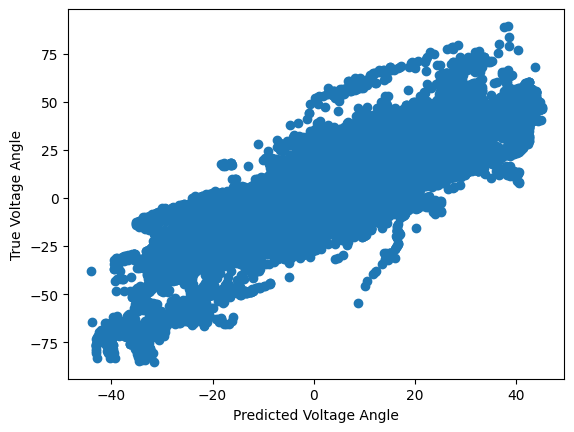

In [78]:
# scatter plot of va_pred_corrected and va
plt.scatter(pf_node["VA_pred_corrected"], pf_node["Va"])
plt.xlabel("Predicted Voltage Angle")
plt.ylabel("True Voltage Angle")
plt.show()



In [62]:
# compute rmse on va_pred_corrected and va
rmse = np.sqrt(np.mean((pf_node["VA_pred_corrected"] - pf_node["Va"])**2))
print(f"RMSE: {rmse}")

# compute rmse on vm_pred_corrected and vm
rmse = np.sqrt(np.mean((pf_node["VM_pred_corrected"] - pf_node["Vm"])**2))
print(f"RMSE: {rmse}")






RMSE: 2.099749654810924
RMSE: 0.04349832564079134


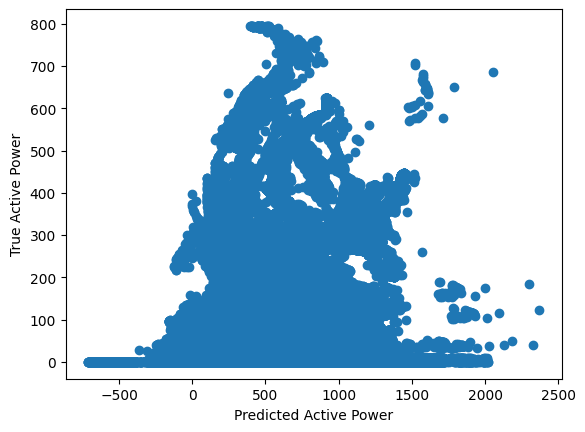

In [59]:
# scatter plot of PD_pred and Pd
plt.scatter(pf_node["PD_pred"], pf_node["Pd"])
plt.xlabel("Predicted Active Power")
plt.ylabel("True Active Power")
plt.show()

